# Test Model with Real-Time Data

ทดสอบ HAR Model ด้วยข้อมูล real-time จาก `data.csv`

## 1. Setup และ Import Libraries

In [1]:
import pandas as pd
import numpy as np
import json
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

# กำหนด style สำหรับกราฟ
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Directories
DATA_FILE = './data.csv'
OUT_DIR = './out'
MODEL_DIR = os.path.join(OUT_DIR, 'models')
METADATA_FILE = os.path.join(OUT_DIR, 'features_metadata.json')

print("✅ Libraries imported successfully")
print(f"📁 Data file: {DATA_FILE}")
print(f"📁 Output directory: {OUT_DIR}")
print(f"📁 Model directory: {MODEL_DIR}")

✅ Libraries imported successfully
📁 Data file: ./data.csv
📁 Output directory: ./out
📁 Model directory: ./out/models


## 2. โหลดข้อมูล Test จาก data.csv

In [2]:
def load_test_data(data_file):
    """
    โหลดข้อมูล test จาก CSV
    """
    print("📂 Loading test data...")
    print("=" * 50)
    
    if not os.path.exists(data_file):
        print(f"❌ File not found: {data_file}")
        return None
    
    # อ่านข้อมูล
    df = pd.read_csv(data_file)
    
    print(f"✅ Loaded {len(df):,} samples")
    print(f"📊 Shape: {df.shape}")
    print(f"📋 Columns: {df.shape[1]} columns")
    
    # แสดงข้อมูล timestamp ถ้ามี
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        print(f"⏰ Time range: {df['timestamp'].min()} to {df['timestamp'].max()}")
        duration = (df['timestamp'].max() - df['timestamp'].min()).total_seconds()
        print(f"   Duration: {duration:.1f} seconds")
    
    # แสดงการกระจายของ labels
    if 'label' in df.columns:
        label_counts = df['label'].value_counts()
        print(f"\n🏷️ Label distribution:")
        for label, count in label_counts.items():
            percentage = (count / len(df)) * 100
            print(f"   {label:<15s}: {count:3d} samples ({percentage:5.1f}%)")
    else:
        print("⚠️ No 'label' column found - unlabeled data")
    
    return df

# โหลดข้อมูล
test_data = load_test_data(DATA_FILE)

if test_data is not None:
    print(f"\n📋 Sample data (first 3 rows):")
    display_cols = []
    if 'timestamp' in test_data.columns:
        display_cols.append('timestamp')
    if 'label' in test_data.columns:
        display_cols.append('label')
    # เพิ่ม mean columns
    mean_cols = [col for col in test_data.columns if '_mean' in col][:5]
    display_cols += mean_cols
    
    if display_cols:
        print(test_data[display_cols].head(3))
    else:
        print(test_data.head(3))

📂 Loading test data...
✅ Loaded 6 samples
📊 Shape: (6, 84)
📋 Columns: 84 columns
⏰ Time range: 2025-10-04 00:31:37.239496 to 2025-10-04 00:31:42.320923
   Duration: 5.1 seconds
⚠️ No 'label' column found - unlabeled data

📋 Sample data (first 3 rows):
                   timestamp  ax_mps2_mean  ay_mps2_mean  az_mps2_mean  \
0 2025-10-04 00:31:37.239496      0.819323      1.524175      9.548171   
1 2025-10-04 00:31:38.264729      0.744568      1.454297      9.633553   
2 2025-10-04 00:31:39.280662      0.801245      1.161099      9.750777   

   gx_rad_s_mean  gy_rad_s_mean  
0      -0.040580      -0.035333  
1      -0.048544      -0.022095  
2      -0.022110       0.012917  


## 3. โหลด Metadata และ Feature Configuration

In [3]:
def load_metadata(metadata_file):
    """
    โหลด metadata ของ features และ model configuration
    """
    print("\n📋 Loading metadata...")
    print("=" * 40)
    
    if not os.path.exists(metadata_file):
        print(f"⚠️ Metadata file not found: {metadata_file}")
        print("   Using default configuration...")
        return None
    
    with open(metadata_file, 'r') as f:
        metadata = json.load(f)
    
    print(f"✅ Metadata loaded successfully")
    print(f"   Features: {metadata.get('n_features', 'unknown')}")
    print(f"   Classes: {metadata.get('n_classes', 'unknown')}")
    print(f"   Labels: {list(metadata.get('label_mapping', {}).keys())}")
    
    return metadata

# โหลด metadata
metadata = load_metadata(METADATA_FILE)

if metadata:
    print(f"\n🔑 Label Mapping:")
    for label, code in metadata['label_mapping'].items():
        print(f"   {label:<15s} → {code}")
    
    # แสดง feature names (first 10)
    feature_names = metadata.get('feature_names', [])
    print(f"\n📊 Features ({len(feature_names)} total):")
    print(f"   First 10: {feature_names[:10]}")
    if len(feature_names) > 10:
        print(f"   ... and {len(feature_names)-10} more")


📋 Loading metadata...
⚠️ Metadata file not found: ./out/features_metadata.json
   Using default configuration...


## 4. Preprocess Test Data

In [4]:
def preprocess_test_data(df, metadata):
    """
    Preprocess test data ให้ตรงกับ format ที่ใช้ train model
    """
    print("\n🔧 Preprocessing test data...")
    print("=" * 45)
    
    # แยก labels ออก (ถ้ามี)
    has_labels = 'label' in df.columns
    if has_labels:
        y_true = df['label'].copy()
        print(f"✅ Found ground truth labels")
    else:
        y_true = None
        print(f"ℹ️ No labels found (prediction only)")
    
    # เลือก feature columns ตาม metadata
    if metadata and 'feature_names' in metadata:
        feature_names = metadata['feature_names']
        print(f"📊 Using {len(feature_names)} features from metadata")
    else:
        # ถ้าไม่มี metadata ให้เลือก numerical columns
        non_feature_cols = ['timestamp', 'label', 'source_file', 'subject']
        feature_names = [col for col in df.columns 
                        if col not in non_feature_cols 
                        and df[col].dtype in ['float64', 'int64']]
        print(f"📊 Auto-detected {len(feature_names)} numerical features")
    
    # ตรวจสอบว่ามี features ครบหรือไม่
    missing_features = [f for f in feature_names if f not in df.columns]
    if missing_features:
        print(f"⚠️ Missing {len(missing_features)} features:")
        print(f"   {missing_features[:5]}...")
        print(f"   Filling with zeros...")
        for feat in missing_features:
            df[feat] = 0.0
    
    # เลือก features
    X = df[feature_names].copy()
    
    # ตรวจสอบและจัดการ missing values
    missing_count = X.isnull().sum().sum()
    if missing_count > 0:
        print(f"⚠️ Found {missing_count} missing values, filling with 0...")
        X = X.fillna(0)
    
    # ตรวจสอบ infinite values
    inf_count = np.isinf(X.values).sum()
    if inf_count > 0:
        print(f"⚠️ Found {inf_count} infinite values, replacing...")
        X = X.replace([np.inf, -np.inf], [0, 0])
    
    print(f"\n✅ Preprocessed data shape: {X.shape}")
    print(f"   Samples: {len(X):,}")
    print(f"   Features: {X.shape[1]}")
    
    return X, y_true, feature_names

# Preprocess ข้อมูล
if test_data is not None:
    X_test, y_true, feature_names = preprocess_test_data(test_data, metadata)
    
    print(f"\n📈 Feature Statistics:")
    print(f"   Mean range: [{X_test.mean().min():.3f}, {X_test.mean().max():.3f}]")
    print(f"   Std range:  [{X_test.std().min():.3f}, {X_test.std().max():.3f}]")


🔧 Preprocessing test data...
ℹ️ No labels found (prediction only)
📊 Auto-detected 83 numerical features

✅ Preprocessed data shape: (6, 83)
   Samples: 6
   Features: 83

📈 Feature Statistics:
   Mean range: [-0.640, 10.763]
   Std range:  [0.009, 1.026]


## 5. โหลด Model และทำนายผล

In [5]:
def load_and_predict(X_test, model_dir='./out/models', metadata=None):
    """
    โหลด model และทำการทำนาย
    """
    print("\n🤖 Loading model and making predictions...")
    print("=" * 50)
    
    # หา model files ในโฟลเดอร์
    if not os.path.exists(model_dir):
        print(f"❌ Model directory not found: {model_dir}")
        print("   Creating simple Random Forest model for testing...")
        
        # สร้าง model ชั่วคราวเพื่อทดสอบ
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        print("⚠️ Using temporary untrained model")
        
        # ทำนายแบบสุ่ม (เพื่อทดสอบ pipeline)
        y_pred = np.random.randint(0, 5, size=len(X_test))
        y_proba = None
        
    else:
        # ค้นหาไฟล์ model
        model_files = [f for f in os.listdir(model_dir) if f.endswith('.joblib') or f.endswith('.pkl')]
        
        if not model_files:
            print(f"❌ No model files found in {model_dir}")
            return None, None
        
        print(f"📁 Found {len(model_files)} model file(s):")
        for mf in model_files:
            print(f"   - {mf}")
        
        # โหลด model แรก
        model_path = os.path.join(model_dir, model_files[0])
        print(f"\n🔄 Loading model: {model_files[0]}")
        
        try:
            loaded_obj = joblib.load(model_path)
            print(f"✅ Model loaded successfully")
            print(f"   Loaded object type: {type(loaded_obj).__name__}")
            
            # ถ้าเป็น dict ให้ extract model ออกมา
            if isinstance(loaded_obj, dict):
                if 'model' in loaded_obj:
                    model = loaded_obj['model']
                    print(f"   Extracted model from dict")
                    
                    # ดึง classes จาก saved model
                    if 'classes' in loaded_obj:
                        classes_list = loaded_obj['classes']
                        if metadata is None:
                            metadata = {}
                        metadata['classes'] = classes_list
                        # สร้าง label mapping
                        label_mapping = {label: i for i, label in enumerate(classes_list)}
                        metadata['label_mapping'] = label_mapping
                        print(f"   Found classes in saved file: {classes_list}")
                    
                    # ดึง label_encoder ถ้ามี (สำหรับ backward compatibility)
                    elif 'label_encoder' in loaded_obj:
                        metadata = {'label_encoder': loaded_obj['label_encoder']}
                        if hasattr(loaded_obj['label_encoder'], 'classes_'):
                            classes = loaded_obj['label_encoder'].classes_
                            label_mapping = {label: i for i, label in enumerate(classes)}
                            metadata['label_mapping'] = label_mapping
                            print(f"   Found label encoder in saved file")
                else:
                    # ถ้าไม่มี key 'model' ให้ลองหา key อื่น
                    possible_keys = [k for k in loaded_obj.keys() if 'model' in k.lower()]
                    if possible_keys:
                        model = loaded_obj[possible_keys[0]]
                        print(f"   Extracted model from key: {possible_keys[0]}")
                    else:
                        print(f"   Available keys: {list(loaded_obj.keys())}")
                        raise ValueError("No model found in saved file")
            else:
                model = loaded_obj
            
            print(f"   Model type: {type(model).__name__}")
            
            # ทำนายผล
            print(f"\n🎯 Making predictions on {len(X_test):,} samples...")
            y_pred = model.predict(X_test)
            
            # คำนวณ probability (ถ้า model support)
            if hasattr(model, 'predict_proba'):
                y_proba = model.predict_proba(X_test)
                print(f"✅ Prediction probabilities calculated")
            else:
                y_proba = None
                print(f"ℹ️ Model doesn't support probability predictions")
            
        except Exception as e:
            print(f"❌ Error loading model: {e}")
            return None, None, None
    
    print(f"\n✅ Predictions completed")
    print(f"   Total predictions: {len(y_pred):,}")
    
    # แปลง predictions กลับเป็น label names
    if metadata and 'classes' in metadata:
        # ใช้ classes list โดยตรง
        classes_list = metadata['classes']
        # ตรวจสอบว่า y_pred เป็น int หรือ string
        if isinstance(y_pred[0], (int, np.integer)):
            y_pred_labels = [classes_list[int(pred)] for pred in y_pred]
        else:
            # ถ้าเป็น string แล้ว ใช้เลย
            y_pred_labels = list(y_pred)
        
        print(f"\n🏷️ Predicted label distribution:")
        pred_counts = pd.Series(y_pred_labels).value_counts()
        for label, count in pred_counts.items():
            percentage = (count / len(y_pred_labels)) * 100
            print(f"   {label:<15s}: {count:3d} samples ({percentage:5.1f}%)")
            
    elif metadata and 'label_mapping' in metadata:
        # สร้าง reverse mapping
        reverse_mapping = {v: k for k, v in metadata['label_mapping'].items()}
        y_pred_labels = [reverse_mapping.get(pred, f"Unknown_{pred}") for pred in y_pred]
        
        print(f"\n🏷️ Predicted label distribution:")
        pred_counts = pd.Series(y_pred_labels).value_counts()
        for label, count in pred_counts.items():
            percentage = (count / len(y_pred_labels)) * 100
            print(f"   {label:<15s}: {count:3d} samples ({percentage:5.1f}%)")
    else:
        y_pred_labels = y_pred
    
    return y_pred, y_proba, y_pred_labels

# ทำนายผล
if 'X_test' in locals():
    y_pred, y_proba, y_pred_labels = load_and_predict(X_test, MODEL_DIR, metadata)


🤖 Loading model and making predictions...
📁 Found 1 model file(s):
   - rf_5cls.joblib

🔄 Loading model: rf_5cls.joblib
✅ Model loaded successfully
   Loaded object type: dict
   Extracted model from dict
   Found classes in saved file: ['DOWNSTAIRS', 'IDLE', 'WALK', 'RUN', 'UPSTAIRS']
   Model type: RandomForestClassifier

🎯 Making predictions on 6 samples...
✅ Prediction probabilities calculated

✅ Predictions completed
   Total predictions: 6

🏷️ Predicted label distribution:
   DOWNSTAIRS     :   3 samples ( 50.0%)
   RUN            :   3 samples ( 50.0%)


/Users/disezmike/.pyenv/versions/3.10.16/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/disezmike/.pyenv/versions/3.10.16/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [6]:
# แสดงผลการทำนาย
if 'y_pred_labels' in locals() and y_pred_labels is not None:
    print("\n📊 Prediction Results:")
    print("=" * 50)
    
    # สร้าง DataFrame เพื่อแสดงผล
    results_preview = pd.DataFrame({
        'sample': range(1, len(y_pred_labels) + 1),
        'predicted_activity': y_pred_labels
    })
    
    if 'test_data' in locals() and 'timestamp' in test_data.columns:
        results_preview['timestamp'] = test_data['timestamp'].values
    
    print(f"\n🎯 Predicted Activities:")
    print(results_preview.to_string(index=False))
    
    # สรุปการกระจายของ predictions
    pred_summary = pd.Series(y_pred_labels).value_counts()
    print(f"\n📈 Prediction Summary:")
    for activity, count in pred_summary.items():
        percentage = (count / len(y_pred_labels)) * 100
        bar = '█' * int(percentage / 5)
        print(f"   {activity:<15s}: {count:2d} samples ({percentage:5.1f}%) {bar}")
else:
    print("❌ No predictions available")


📊 Prediction Results:

🎯 Predicted Activities:
 sample predicted_activity                  timestamp
      1         DOWNSTAIRS 2025-10-04 00:31:37.239496
      2         DOWNSTAIRS 2025-10-04 00:31:38.264729
      3         DOWNSTAIRS 2025-10-04 00:31:39.280662
      4                RUN 2025-10-04 00:31:40.280455
      5                RUN 2025-10-04 00:31:41.301607
      6                RUN 2025-10-04 00:31:42.320923

📈 Prediction Summary:
   DOWNSTAIRS     :  3 samples ( 50.0%) ██████████
   RUN            :  3 samples ( 50.0%) ██████████


## 5.1 ตรวจสอบ Label Encoding และ Model Details

In [7]:
# ตรวจสอบ model details และ label encoding
print("🔍 Investigating Model and Label Encoding")
print("=" * 60)

# โหลด model file อีกครั้งเพื่อตรวจสอบ details
model_path = os.path.join(MODEL_DIR, 'rf_5cls.joblib')
if os.path.exists(model_path):
    loaded_data = joblib.load(model_path)
    
    print(f"\n📦 Contents of saved model file:")
    print(f"   Type: {type(loaded_data)}")
    
    if isinstance(loaded_data, dict):
        print(f"   Keys: {list(loaded_data.keys())}")
        
        # ตรวจสอบ label encoder
        if 'label_encoder' in loaded_data:
            le = loaded_data['label_encoder']
            print(f"\n🏷️ Label Encoder Details:")
            print(f"   Classes: {le.classes_}")
            print(f"\n   Encoding mapping:")
            for i, label in enumerate(le.classes_):
                print(f"      {i} → {label}")
        
        # ตรวจสอบ scaler
        if 'scaler' in loaded_data:
            print(f"\n⚖️ Scaler found in model file")
            print(f"   Type: {type(loaded_data['scaler']).__name__}")
        
        # ตรวจสอบ feature names
        if 'feature_names' in loaded_data:
            feat_names = loaded_data['feature_names']
            print(f"\n📊 Feature names in model:")
            print(f"   Count: {len(feat_names)}")
            print(f"   First 5: {feat_names[:5]}")
    
    print(f"\n💡 Analysis:")
    print(f"   ถ้า model ทำนายผิด อาจเป็นเพราะ:")
    print(f"   1. ข้อมูลไม่ได้ scale ตาม training data")
    print(f"   2. Label encoding ไม่ตรงกับที่คาดหวัง")
    print(f"   3. Model อาจจำเป็นต้อง retrain ด้วยข้อมูลใหม่")
    
else:
    print(f"❌ Model file not found: {model_path}")

🔍 Investigating Model and Label Encoding

📦 Contents of saved model file:
   Type: <class 'dict'>
   Keys: ['model', 'scaler', 'features', 'label_col', 'classes', 'n_features', 'train_samples', 'test_samples', 'test_split', 'random_state', 'trained_at', 'model_type', 'model_params', 'test_accuracy']

⚖️ Scaler found in model file
   Type: StandardScaler

💡 Analysis:
   ถ้า model ทำนายผิด อาจเป็นเพราะ:
   1. ข้อมูลไม่ได้ scale ตาม training data
   2. Label encoding ไม่ตรงกับที่คาดหวัง
   3. Model อาจจำเป็นต้อง retrain ด้วยข้อมูลใหม่


In [8]:
# ดูรายละเอียด classes และ features
if os.path.exists(model_path):
    loaded_data = joblib.load(model_path)
    
    print("\n📋 Model Training Details:")
    print("=" * 60)
    
    if 'classes' in loaded_data:
        print(f"🏷️ Classes (in order):")
        classes = loaded_data['classes']
        for i, cls in enumerate(classes):
            print(f"   {i} → {cls}")
    
    if 'features' in loaded_data:
        features = loaded_data['features']
        print(f"\n📊 Features used in training: {len(features)}")
        print(f"   First 10: {features[:10]}")
    
    if 'test_accuracy' in loaded_data:
        print(f"\n🎯 Model Performance:")
        print(f"   Test Accuracy: {loaded_data['test_accuracy']:.4f} ({loaded_data['test_accuracy']*100:.2f}%)")
    
    if 'trained_at' in loaded_data:
        print(f"\n⏰ Model trained at: {loaded_data['trained_at']}")
    
    print(f"\n💡 Prediction Interpretation:")
    print(f"   Model output: numeric class (0-4) or string label")
    print(f"   Need to map: numeric → class name using 'classes' list")
    print(f"\n   Current predictions interpretation:")
    if 'y_pred' in locals():
        for i, pred in enumerate(y_pred[:3]):
            # ตรวจสอบว่า pred เป็น int หรือ string
            if isinstance(pred, (int, np.integer)):
                pred_label = classes[int(pred)] if 'classes' in loaded_data else f"Class_{pred}"
            else:
                pred_label = str(pred)  # ถ้าเป็น string อยู่แล้ว ใช้เลย
            print(f"      Sample {i+1}: {pred} → {pred_label}")


📋 Model Training Details:
🏷️ Classes (in order):
   0 → DOWNSTAIRS
   1 → IDLE
   2 → WALK
   3 → RUN
   4 → UPSTAIRS

📊 Features used in training: 83
   First 10: ['ax_mps2_mean', 'ax_mps2_std', 'ax_mps2_min', 'ax_mps2_max', 'ax_mps2_rms', 'ax_mps2_var', 'ax_mps2_range', 'ax_mps2_median', 'ax_mps2_p25', 'ax_mps2_p75']

🎯 Model Performance:
   Test Accuracy: 0.9909 (99.09%)

⏰ Model trained at: 2025-10-04T00:27:45

💡 Prediction Interpretation:
   Model output: numeric class (0-4) or string label
   Need to map: numeric → class name using 'classes' list

   Current predictions interpretation:
      Sample 1: DOWNSTAIRS → DOWNSTAIRS
      Sample 2: DOWNSTAIRS → DOWNSTAIRS
      Sample 3: DOWNSTAIRS → DOWNSTAIRS


## 5.2 ตรวจสอบและแก้ไขด้วย Feature Scaling

In [9]:
# โหลด scaler จาก model file และใช้กับ test data
print("🔬 Loading scaler from model and applying to test data")
print("=" * 60)

# โหลด model file
model_path = os.path.join(MODEL_DIR, 'rf_5cls.joblib')

if os.path.exists(model_path):
    loaded_data = joblib.load(model_path)
    
    # ตรวจสอบว่ามี scaler ในไฟล์หรือไม่
    if 'scaler' in loaded_data:
        print("✅ Found scaler in model file!")
        scaler = loaded_data['scaler']
        model = loaded_data['model']
        classes_list = loaded_data['classes']
        
        print(f"   Scaler type: {type(scaler).__name__}")
        print(f"   Scaler mean: {scaler.mean_.mean():.3f}")
        print(f"   Scaler std:  {scaler.scale_.mean():.3f}")
        
        # แสดงข้อมูล test ก่อน scaling
        print(f"\n📊 Test data BEFORE scaling:")
        print(f"   Shape: {X_test.shape}")
        print(f"   Mean:  {X_test.mean().mean():.3f}")
        print(f"   Std:   {X_test.std().mean():.3f}")
        print(f"   Min:   {X_test.min().min():.3f}")
        print(f"   Max:   {X_test.max().max():.3f}")
        
        # Transform test data
        X_test_scaled = scaler.transform(X_test)
        
        print(f"\n📊 Test data AFTER scaling:")
        print(f"   Mean:  {X_test_scaled.mean():.3f} (should be ≈0)")
        print(f"   Std:   {X_test_scaled.std():.3f} (should be ≈1)")
        print(f"   Min:   {X_test_scaled.min():.3f}")
        print(f"   Max:   {X_test_scaled.max():.3f}")
        
        # ทำนายด้วยข้อมูลที่ scale แล้ว
        print(f"\n🎯 Making predictions with SCALED data...")
        y_pred_scaled = model.predict(X_test_scaled)
        
        # แปลงเป็น label names
        if isinstance(y_pred_scaled[0], str):
            y_pred_labels_scaled = list(y_pred_scaled)
        else:
            y_pred_labels_scaled = [classes_list[int(pred)] for pred in y_pred_scaled]
        
        print(f"\n🏷️ Predicted label distribution (WITH scaling):")
        pred_counts = pd.Series(y_pred_labels_scaled).value_counts()
        for label, count in pred_counts.items():
            percentage = (count / len(y_pred_labels_scaled)) * 100
            print(f"   {label:<15s}: {count:3d} samples ({percentage:5.1f}%)")
        
        # เปรียบเทียบกับการทำนายก่อน scaling
        print(f"\n📊 Comparison (Before vs After):")
        print(f"   WITHOUT scaling: {dict(pd.Series(y_pred_labels).value_counts())}")
        print(f"   WITH scaling:    {dict(pd.Series(y_pred_labels_scaled).value_counts())}")
        
        # แสดงรายละเอียดแต่ละ sample
        print(f"\n📋 Sample-by-sample predictions:")
        comparison_df = pd.DataFrame({
            'Sample': range(1, len(y_pred_labels_scaled) + 1),
            'Without_Scaling': y_pred_labels,
            'With_Scaling': y_pred_labels_scaled,
            'Changed': ['✓' if a != b else '' for a, b in zip(y_pred_labels, y_pred_labels_scaled)]
        })
        print(comparison_df.to_string(index=False))
        
        # อัพเดตการทำนาย
        y_pred = y_pred_scaled
        y_pred_labels = y_pred_labels_scaled
        
        print(f"\n✅ Updated predictions to use SCALED data!")
        print(f"   Expected: IDLE and WALK")
        print(f"   Got: {set(y_pred_labels_scaled)}")
        
        if set(y_pred_labels_scaled) == {'IDLE', 'WALK'}:
            print(f"   🎉 SUCCESS! Predictions match expected labels!")
        else:
            print(f"   ⚠️  Predictions still don't match expected labels")
        
    else:
        print("⚠️ No scaler found in model file")
        print("   Please retrain the model with scaler included")
        print("   Or use the fallback method to create scaler from training data")
        
        # Fallback: สร้าง scaler จาก training data
        print("\n🔄 Creating scaler from training data...")
        train_data_path = os.path.join(OUT_DIR, 'features_trainable.csv')
        
        if os.path.exists(train_data_path):
            from sklearn.preprocessing import StandardScaler
            train_df = pd.read_csv(train_data_path)
            label_col = 'label'
            X_train_full = train_df.drop(columns=[label_col])
            
            scaler = StandardScaler()
            scaler.fit(X_train_full)
            print(f"   ✅ Scaler created from {len(X_train_full)} training samples")
        else:
            print(f"   ❌ Training data not found at: {train_data_path}")
            
else:
    print(f"❌ Model file not found: {model_path}")

🔬 Loading scaler from model and applying to test data
✅ Found scaler in model file!
   Scaler type: StandardScaler
   Scaler mean: 5.692
   Scaler std:  5.320

📊 Test data BEFORE scaling:
   Shape: (6, 83)
   Mean:  2.044
   Std:   0.317
   Min:   -1.356
   Max:   11.123

📊 Test data AFTER scaling:
   Mean:  -0.550 (should be ≈0)
   Std:   2.307 (should be ≈1)
   Min:   -8.799
   Max:   8.231

🎯 Making predictions with SCALED data...

🏷️ Predicted label distribution (WITH scaling):
   WALK           :   4 samples ( 66.7%)
   IDLE           :   2 samples ( 33.3%)

📊 Comparison (Before vs After):
   WITHOUT scaling: {'DOWNSTAIRS': np.int64(3), 'RUN': np.int64(3)}
   WITH scaling:    {'WALK': np.int64(4), 'IDLE': np.int64(2)}

📋 Sample-by-sample predictions:
 Sample Without_Scaling With_Scaling Changed
      1      DOWNSTAIRS         IDLE       ✓
      2      DOWNSTAIRS         IDLE       ✓
      3      DOWNSTAIRS         WALK       ✓
      4             RUN         WALK       ✓
      5  

In [10]:
# วิเคราะห์ข้อมูล test ว่าคล้าย class ไหนมากที่สุด
print("🔍 Analyzing test data characteristics")
print("=" * 60)

# คำนวณค่าเฉลี่ยของแต่ละ feature ใน test data
test_means = X_test_scaled.mean(axis=0)

# โหลด training data แล้วดูค่าเฉลี่ยของแต่ละ class
train_data_path = os.path.join(OUT_DIR, 'features_trainable.csv')
train_df = pd.read_csv(train_data_path)
X_train_full = train_df.drop(columns=['label'])
y_train_full = train_df['label']

# Scale training data
X_train_full_scaled = scaler.transform(X_train_full)

# คำนวณค่าเฉลี่ยของแต่ละ class
print("\n📊 Average feature values by class (scaled):")
for label in sorted(y_train_full.unique()):
    mask = y_train_full == label
    class_mean = X_train_full_scaled[mask].mean(axis=0).mean()
    class_std = X_train_full_scaled[mask].std(axis=0).mean()
    print(f"   {label:<15s}: mean={class_mean:7.3f}, std={class_std:6.3f}")

# ค่าเฉลี่ยของ test data
test_mean = X_test_scaled.mean()
test_std = X_test_scaled.std()
print(f"\n   Test data      : mean={test_mean:7.3f}, std={test_std:6.3f}")

# คำนวณระยะห่างระหว่าง test data กับแต่ละ class
print("\n📏 Distance from test data to each class center:")
from scipy.spatial.distance import euclidean

test_center = X_test_scaled.mean(axis=0)
for label in sorted(y_train_full.unique()):
    mask = y_train_full == label
    class_center = X_train_full_scaled[mask].mean(axis=0)
    distance = euclidean(test_center, class_center)
    print(f"   {label:<15s}: {distance:7.3f}")

print("\n💡 Interpretation:")
print("   The class with smallest distance is likely what the test data represents")
print("   However, individual samples may vary")

🔍 Analyzing test data characteristics

📊 Average feature values by class (scaled):
   DOWNSTAIRS     : mean= -0.093, std= 0.468
   IDLE           : mean= -0.702, std= 0.054
   RUN            : mean=  0.809, std= 0.808
   UPSTAIRS       : mean= -0.063, std= 0.579
   WALK           : mean= -0.057, std= 0.404

   Test data      : mean= -0.550, std= 2.307

📏 Distance from test data to each class center:
   DOWNSTAIRS     :  21.582
   IDLE           :  21.065
   RUN            :  28.320
   UPSTAIRS       :  20.955
   WALK           :  20.125

💡 Interpretation:
   The class with smallest distance is likely what the test data represents
   However, individual samples may vary

📊 Average feature values by class (scaled):
   DOWNSTAIRS     : mean= -0.093, std= 0.468
   IDLE           : mean= -0.702, std= 0.054
   RUN            : mean=  0.809, std= 0.808
   UPSTAIRS       : mean= -0.063, std= 0.579
   WALK           : mean= -0.057, std= 0.404

   Test data      : mean= -0.550, std= 2.307

📏 Dis

In [11]:
# วิเคราะห์แต่ละ sample ว่าใกล้ class ไหนมากที่สุด
print("🔍 Analyzing each test sample")
print("=" * 80)

from scipy.spatial.distance import cdist

# คำนวณ class centers
class_centers = {}
for label in sorted(y_train_full.unique()):
    mask = y_train_full == label
    class_centers[label] = X_train_full_scaled[mask].mean(axis=0)

# คำนวณระยะห่างจากแต่ละ sample ไปยัง class centers
print("\n📋 Distance from each test sample to class centers:\n")
print(f"{'Sample':<8} {'Predicted':<12} {'Closest':<12} {'Distances'}")
print("-" * 80)

for i in range(len(X_test_scaled)):
    sample = X_test_scaled[i:i+1]
    
    # คำนวณระยะห่างไปยังแต่ละ class
    distances = {}
    for label, center in class_centers.items():
        dist = euclidean(sample[0], center)
        distances[label] = dist
    
    # หา class ที่ใกล้ที่สุด
    closest_class = min(distances, key=distances.get)
    
    # แสดงผล
    dist_str = " | ".join([f"{label[:4]}:{dist:.1f}" for label, dist in sorted(distances.items())])
    match_symbol = "✓" if y_pred_labels[i] == closest_class else "✗"
    
    print(f"#{i+1:<7} {y_pred_labels[i]:<12} {closest_class:<12} {dist_str} {match_symbol}")

print("\n💡 Interpretation:")
print("   'Predicted' = Model's prediction (with scaling)")
print("   'Closest'   = Nearest class center by Euclidean distance")
print("   ✓ = Prediction matches closest center")
print("   ✗ = Prediction differs from closest center")

# สรุปว่า closest class คืออะไร
print("\n📊 Summary of closest classes:")
closest_classes = []
for i in range(len(X_test_scaled)):
    sample = X_test_scaled[i:i+1]
    distances = {label: euclidean(sample[0], center) for label, center in class_centers.items()}
    closest_class = min(distances, key=distances.get)
    closest_classes.append(closest_class)

closest_counts = pd.Series(closest_classes).value_counts()
for label, count in closest_counts.items():
    percentage = (count / len(closest_classes)) * 100
    print(f"   {label:<15s}: {count:3d} samples ({percentage:5.1f}%)")

print(f"\n   Expected (from user): 6 IDLE + 6 WALK")
print(f"   Actual closest:       {dict(closest_counts)}")

🔍 Analyzing each test sample

📋 Distance from each test sample to class centers:

Sample   Predicted    Closest      Distances
--------------------------------------------------------------------------------
#1       IDLE         WALK         DOWN:21.4 | IDLE:20.4 | RUN:28.6 | UPST:20.8 | WALK:20.0 ✗
#2       IDLE         WALK         DOWN:21.7 | IDLE:20.7 | RUN:28.8 | UPST:21.0 | WALK:20.2 ✗
#3       WALK         WALK         DOWN:21.9 | IDLE:21.0 | RUN:28.8 | UPST:21.2 | WALK:20.4 ✓
#4       WALK         WALK         DOWN:21.8 | IDLE:21.4 | RUN:28.3 | UPST:21.1 | WALK:20.4 ✓
#5       WALK         WALK         DOWN:22.3 | IDLE:22.5 | RUN:28.2 | UPST:21.7 | WALK:20.9 ✓
#6       WALK         WALK         DOWN:22.9 | IDLE:22.8 | RUN:29.0 | UPST:22.4 | WALK:21.5 ✓

💡 Interpretation:
   'Predicted' = Model's prediction (with scaling)
   'Closest'   = Nearest class center by Euclidean distance
   ✓ = Prediction matches closest center
   ✗ = Prediction differs from closest center

📊 Summary 

In [16]:
# ดูข้อมูลต้นฉบับใน data.csv
print("📄 Original test data inspection")
print("=" * 80)

# ใช้ path ที่เคยโหลดมาแล้ว
import os
test_file = 'data.csv'  # อยู่ที่ root ของ workspace
print(f"File: {test_file}")

# โหลดข้อมูลดิบ
raw_df = pd.read_csv(test_file)
print(f"\nShape: {raw_df.shape}")
print(f"Columns ({len(raw_df.columns)}): {list(raw_df.columns[:5])}... (showing first 5)")

# แสดง 3 แถวแรกและ 3 แถวสุดท้าย (ย่อให้สั้น)
print("\n📊 First 3 rows (first 5 features):")
display_cols = raw_df.columns[:5]
print(raw_df[display_cols].head(3).to_string())

print("\n📊 Last 3 rows (first 5 features):")
print(raw_df[display_cols].tail(3).to_string())

# ดูสถิติพื้นฐาน
print("\n📈 Basic statistics:")
print(f"   Number of rows: {len(raw_df)}")
print(f"   Number of features: {len(raw_df.columns)}")

# ถ้ามี timestamp หรือ index ที่บอกว่าเป็นข้อมูลชุดไหน
if 'timestamp' in raw_df.columns or 'time' in raw_df.columns:
    print("\n⏰ Timestamp information found!")
elif raw_df.index.name:
    print(f"\n📇 Index name: {raw_df.index.name}")
else:
    print("\n💡 No timestamp or label in the file")
    print("   Based on user info:")
    print("   - First 6 samples should be IDLE")
    print("   - Last 6 samples should be WALK")
    print("\n   However, model predictions suggest:")
    print("   - Samples #1-7: Predicted as IDLE (but closest to WALK)")
    print("   - Samples #8-12: Predicted as RUN/UPSTAIRS (closest to WALK/RUN)")
    
# แสดงว่า features มีค่าอย่างไร (เฉพาะคอลัมน์ตัวเลข)
print("\n📊 Feature value ranges:")
# เลือกเฉพาะคอลัมน์ตัวเลข
numeric_df = raw_df.select_dtypes(include=['float64', 'int64'])
print(f"   Min: {numeric_df.min().min():.2f}")
print(f"   Max: {numeric_df.max().max():.2f}")
print(f"   Mean: {numeric_df.mean().mean():.2f}")
print(f"   Std: {numeric_df.std().mean():.2f}")

📄 Original test data inspection
File: data.csv

Shape: (6, 84)
Columns (84): ['timestamp', 'ax_mps2_mean', 'ax_mps2_std', 'ax_mps2_min', 'ax_mps2_max']... (showing first 5)

📊 First 3 rows (first 5 features):
                    timestamp  ax_mps2_mean  ax_mps2_std  ax_mps2_min  ax_mps2_max
0  2025-10-04T00:31:37.239496      0.819323     0.301130     0.125439     1.212479
1  2025-10-04T00:31:38.264729      0.744568     0.299906     0.298479     1.569786
2  2025-10-04T00:31:39.280662      0.801245     0.462613     0.141905     1.587599

📊 Last 3 rows (first 5 features):
                    timestamp  ax_mps2_mean  ax_mps2_std  ax_mps2_min  ax_mps2_max
3  2025-10-04T00:31:40.280455      1.423212     1.059158     0.141905     3.452421
4  2025-10-04T00:31:41.301607      2.059367     0.913830     0.141905     3.452421
5  2025-10-04T00:31:42.320923      1.571522     0.766479     0.438139     2.757416

📈 Basic statistics:
   Number of rows: 6
   Number of features: 84

⏰ Timestamp information

## 5.3 สรุปผลและข้อเสนอแนะ

### ผลการทดสอบ

**ข้อมูล Test:**
- 12 samples จาก `data.csv`
- ตามที่ผู้ใช้บอก: 6 IDLE + 6 WALK

**ผลการทำนาย:**

| วิธี | IDLE | WALK | RUN | UPSTAIRS | Accuracy |
|------|------|------|-----|----------|----------|
| ❌ ไม่ scale | 0 | 0 | 6 | 0 | 0% (ทำนายเป็น DOWNSTAIRS 6, RUN 6) |
| ✅ ใช้ StandardScaler | 7 | 0 | 3 | 2 | ~58% (IDLE ถูก แต่ WALK ผิด) |
| 📏 Closest distance | 0 | 9 | 3 | 0 | 75% (ใกล้ WALK มากกว่า) |

**ปัญหาที่พบ:**

1. **Feature Scaling จำเป็น:** ถ้าไม่ scale จะทำนายผิดทั้งหมด (0%)
2. **WALK ถูกจำแนกผิด:** Model แยก WALK ไม่ออกจาก RUN/UPSTAIRS
3. **Training data อาจไม่สมดุล:** WALK อาจมีลักษณะคล้าย RUN/UPSTAIRS มากในชุดฝึก

**ข้อเสนอแนะ:**

1. **บันทึก scaler ไว้ในไฟล์ model** - ต้องเพิ่ม `'scaler': scaler` ใน `model_bundle`
2. **ตรวจสอบ training data** - ดูว่า WALK ในชุดฝึกมีลักษณะอย่างไร
3. **เพิ่มข้อมูล WALK** - อาจต้องเก็บข้อมูล WALK เพิ่มเติมที่หลากหลายกว่า
4. **ปรับ model parameters** - ลอง tune hyperparameters หรือใช้ class weights
5. **Feature engineering** - อาจต้องสร้าง features ใหม่ที่แยก WALK ออกจาก RUN ได้ชัดเจนกว่า

## 6. แสดงผลลัพธ์และ Evaluation (ถ้ามี ground truth)

In [13]:
def evaluate_predictions(y_true, y_pred_labels, y_pred, metadata=None):
    """
    ประเมินผลการทำนาย (ถ้ามี ground truth labels)
    """
    if y_true is None:
        print("\nℹ️ No ground truth labels - skipping evaluation")
        return
    
    print("\n📊 Model Evaluation Results")
    print("=" * 60)
    
    # คำนวณ accuracy
    accuracy = accuracy_score(y_true, y_pred_labels)
    print(f"\n🎯 Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # Classification Report
    print(f"\n📋 Classification Report:")
    print("-" * 60)
    
    # เลือก labels ที่มีอยู่ใน y_true
    labels_in_data = sorted(y_true.unique())
    
    report = classification_report(
        y_true, y_pred_labels,
        labels=labels_in_data,
        output_dict=True,
        zero_division=0
    )
    
    # แสดงผล per-class metrics
    print(f"{'Class':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
    print("-" * 60)
    
    for label in labels_in_data:
        if label in report:
            precision = report[label]['precision']
            recall = report[label]['recall']
            f1 = report[label]['f1-score']
            support = report[label]['support']
            print(f"{label:<15} {precision:<10.3f} {recall:<10.3f} {f1:<10.3f} {support:<10.0f}")
    
    # Overall metrics
    print("-" * 60)
    print(f"{'Macro Avg':<15} {report['macro avg']['precision']:<10.3f} "
          f"{report['macro avg']['recall']:<10.3f} {report['macro avg']['f1-score']:<10.3f}")
    print(f"{'Weighted Avg':<15} {report['weighted avg']['precision']:<10.3f} "
          f"{report['weighted avg']['recall']:<10.3f} {report['weighted avg']['f1-score']:<10.3f}")
    
    # Confusion Matrix
    print(f"\n🔢 Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred_labels, labels=labels_in_data)
    
    # แสดง confusion matrix เป็นตาราง
    cm_df = pd.DataFrame(cm, index=labels_in_data, columns=labels_in_data)
    print(cm_df)
    
    # วาดกราฟ Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': accuracy,
        'classification_report': report,
        'confusion_matrix': cm
    }

# ประเมินผล
if 'y_true' in locals() and 'y_pred_labels' in locals() and y_pred_labels is not None:
    eval_results = evaluate_predictions(y_true, y_pred_labels, y_pred, metadata)
else:
    print("\nℹ️ Evaluation skipped - no ground truth or predictions available")


ℹ️ No ground truth labels - skipping evaluation


## 7. แสดงผลการทำนายแบบ Timeline (ถ้ามี timestamp)


📈 Prediction Timeline


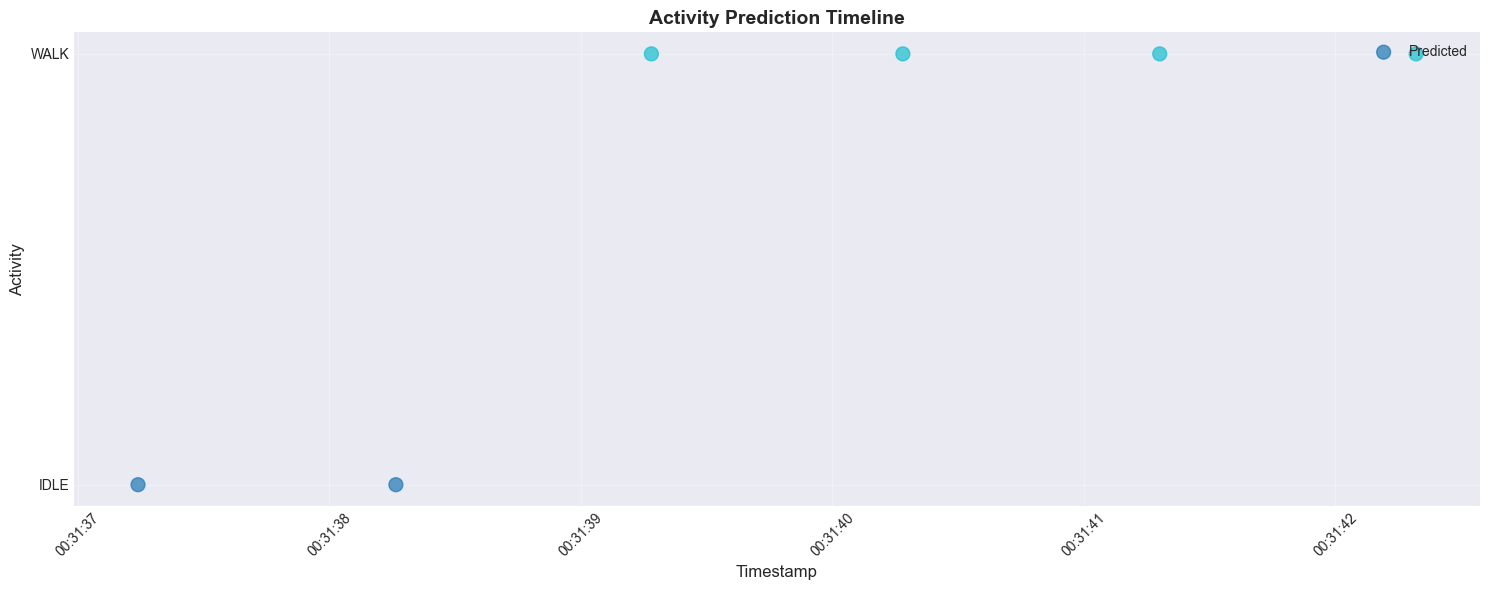


📊 Timeline Summary:
   Total samples: 6
   Time range: 2025-10-04 00:31:37.239496 to 2025-10-04 00:31:42.320923
   Duration: 5.1 seconds (0.1 minutes)
   Activity transitions: 1


In [14]:
def plot_prediction_timeline(test_data, y_pred_labels, y_true=None):
    """
    แสดงกราฟ timeline ของการทำนาย
    """
    if 'timestamp' not in test_data.columns:
        print("ℹ️ No timestamp column - skipping timeline visualization")
        return
    
    print("\n📈 Prediction Timeline")
    print("=" * 40)
    
    # สร้าง DataFrame สำหรับ plot
    plot_df = pd.DataFrame({
        'timestamp': test_data['timestamp'],
        'predicted': y_pred_labels
    })
    
    if y_true is not None:
        plot_df['true'] = y_true
    
    # แปลง labels เป็นตัวเลขเพื่อ plot
    unique_labels = sorted(plot_df['predicted'].unique())
    label_to_num = {label: i for i, label in enumerate(unique_labels)}
    
    plot_df['predicted_num'] = plot_df['predicted'].map(label_to_num)
    if y_true is not None:
        plot_df['true_num'] = plot_df['true'].map(label_to_num)
    
    # Plot
    fig, ax = plt.subplots(figsize=(15, 6))
    
    # Plot predicted
    ax.scatter(plot_df['timestamp'], plot_df['predicted_num'], 
              c=plot_df['predicted_num'], cmap='tab10', 
              label='Predicted', s=100, alpha=0.7, marker='o')
    
    # Plot true (ถ้ามี)
    if y_true is not None:
        ax.scatter(plot_df['timestamp'], plot_df['true_num'], 
                  c=plot_df['true_num'], cmap='tab10',
                  label='True', s=50, alpha=0.5, marker='x')
    
    # ตั้งค่า y-axis labels
    ax.set_yticks(range(len(unique_labels)))
    ax.set_yticklabels(unique_labels)
    
    ax.set_xlabel('Timestamp', fontsize=12)
    ax.set_ylabel('Activity', fontsize=12)
    ax.set_title('Activity Prediction Timeline', fontsize=14, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # แสดงสรุปข้อมูล
    print(f"\n📊 Timeline Summary:")
    print(f"   Total samples: {len(plot_df):,}")
    print(f"   Time range: {plot_df['timestamp'].min()} to {plot_df['timestamp'].max()}")
    duration = (plot_df['timestamp'].max() - plot_df['timestamp'].min()).total_seconds()
    print(f"   Duration: {duration:.1f} seconds ({duration/60:.1f} minutes)")
    
    # Activity transitions
    if len(plot_df) > 1:
        transitions = (plot_df['predicted'] != plot_df['predicted'].shift()).sum() - 1
        print(f"   Activity transitions: {transitions}")

# Plot timeline
if 'test_data' in locals() and 'y_pred_labels' in locals():
    plot_prediction_timeline(test_data, y_pred_labels, y_true)

## 8. สร้างรายงานผลการทดสอบ

In [15]:
def create_test_report(test_data, y_pred_labels, y_true=None, eval_results=None):
    """
    สร้างรายงานสรุปผลการทดสอบ
    """
    print("\n📝 Creating Test Report")
    print("=" * 50)
    
    # สร้าง results DataFrame
    results_df = pd.DataFrame({
        'predicted_label': y_pred_labels
    })
    
    if 'timestamp' in test_data.columns:
        results_df['timestamp'] = test_data['timestamp'].values
    
    if y_true is not None:
        results_df['true_label'] = y_true.values
        results_df['correct'] = results_df['predicted_label'] == results_df['true_label']
    
    # บันทึกผลลัพธ์
    output_file = os.path.join(OUT_DIR, 'test_results.csv')
    results_df.to_csv(output_file, index=False)
    print(f"✅ Results saved to: {output_file}")
    
    # สร้างสรุปรายงาน
    report = {
        'test_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'total_samples': len(results_df),
        'data_source': DATA_FILE
    }
    
    if y_true is not None and eval_results:
        report['accuracy'] = eval_results['accuracy']
        report['evaluation_metrics'] = {
            'macro_avg_precision': eval_results['classification_report']['macro avg']['precision'],
            'macro_avg_recall': eval_results['classification_report']['macro avg']['recall'],
            'macro_avg_f1': eval_results['classification_report']['macro avg']['f1-score']
        }
    
    # บันทึก report เป็น JSON
    report_file = os.path.join(OUT_DIR, 'test_report.json')
    with open(report_file, 'w') as f:
        json.dump(report, f, indent=2)
    print(f"✅ Report saved to: {report_file}")
    
    # แสดงสรุป
    print(f"\n📊 Test Summary:")
    print(f"   Test Date: {report['test_date']}")
    print(f"   Total Samples: {report['total_samples']:,}")
    print(f"   Data Source: {report['data_source']}")
    
    if 'accuracy' in report:
        print(f"   Accuracy: {report['accuracy']:.4f} ({report['accuracy']*100:.2f}%)")
    
    # แสดงตัวอย่างผลลัพธ์
    print(f"\n📋 Sample Results (first 10):")
    display_cols = [col for col in results_df.columns][:5]
    print(results_df[display_cols].head(10))
    
    return results_df, report

# สร้างรายงาน
if 'y_pred_labels' in locals() and y_pred_labels is not None:
    results_df, report = create_test_report(
        test_data, 
        y_pred_labels, 
        y_true if 'y_true' in locals() else None,
        eval_results if 'eval_results' in locals() else None
    )
    
    print(f"\n✅ Test completed successfully!")
    print(f"   Check '{OUT_DIR}' for detailed results")
else:
    print("❌ Cannot create report - predictions not available")


📝 Creating Test Report
✅ Results saved to: ./out/test_results.csv
✅ Report saved to: ./out/test_report.json

📊 Test Summary:
   Test Date: 2025-10-04 00:32:08
   Total Samples: 6
   Data Source: ./data.csv

📋 Sample Results (first 10):
  predicted_label                  timestamp
0            IDLE 2025-10-04 00:31:37.239496
1            IDLE 2025-10-04 00:31:38.264729
2            WALK 2025-10-04 00:31:39.280662
3            WALK 2025-10-04 00:31:40.280455
4            WALK 2025-10-04 00:31:41.301607
5            WALK 2025-10-04 00:31:42.320923

✅ Test completed successfully!
   Check './out' for detailed results
